<a href="https://colab.research.google.com/github/inesbsilveira/hummingbirds/blob/main/Risk_classification/all_risks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geemap
!pip install geojson

In [3]:

import os
import csv
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon, mapping
from shapely.validation import make_valid
import geojson
import ee
import geemap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import seaborn as sns
import ee
import datetime
import math
from math import tan
import folium

In [4]:

my_project = 'ee-ineshummingbirds'
ee.Authenticate()
ee.Initialize(project= my_project)


In [5]:
# Define the period of time for temperature and precipitation
start_date = '2024-01-01'
end_date = '2024-12-31'
wf_startDate = '2000-01-01'
wf_endDate = '2024-12-31'

In [7]:

# if the input is a shapefile
input_shp = "ProjectArea_Talia1_reprojected4326.shp"
gdf = gpd.read_file(input_shp).to_crs('EPSG:4326')
region = geemap.geopandas_to_ee(gdf)


In [46]:
#FUNCTIONS
# Count the number of days with at least one pixel exceeding the threshold
def count_hot_days(image):
    mask = image.reduceRegion(
        reducer=ee.Reducer.anyNonZero(),
        geometry=region,
        scale=1000,
        maxPixels=1e8
    )
    is_above = ee.Algorithms.If(mask.get('temperature_2m'), 1, 0)
    return ee.Feature(None, {'date': image.get('system:time_start'), 'day_above_32': is_above})

def count_flood_events(year):
    start_date = ee.Date.fromYMD(year, 1, 1)
    end_date = ee.Date.fromYMD(year, 12, 31)

    yearly_floods = (gfd.filterDate(start_date, end_date)
                      .select('flooded')
                      .map(lambda img: img.gt(0).And(jrc.Not()))
                      .sum()
                      .gt(0))

    clipped_flood = yearly_floods.clip(region)

    flood_check = clipped_flood.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=region.geometry(),
        scale=500,
        maxPixels=1e8
    )

    return ee.Feature(None, {'year': year, 'flood_count': flood_check.get('flooded')})

def get_shapefile_centroid(gdf):
    if gdf.crs is None or gdf.crs.is_projected:
        gdf = gdf.to_crs(epsg=4326)  # Convert to WGS84 (lat/lon)

    #centroid = gdf.unary_union.centroid
    centroid = gdf.geometry.union_all().centroid
    return centroid.y, centroid.x  # (latitude, longitude)

def get_best_crs(latitude, longitude):
    utm_zone = int((180 + longitude) / 6) + 1
    return f"EPSG:{32600 + utm_zone if latitude >= 0 else 32700 + utm_zone}"

# Define slope class ranges
"""
def classify_slope(slope):
    return (slope
            .where(slope.lte(2), 1)   # Flat to very gently sloping (Very low)
            .where(slope.gt(2).And(slope.lte(5)), 2)  # Gently sloping (Low)
            .where(slope.gt(5).And(slope.lte(10)), 3)  # Sloping (Medium)
            .where(slope.gt(10).And(slope.lte(15)), 4)  # Strongly sloping (High)
            .where(slope.gt(15).And(slope.lte(30)), 5)  # Moderately steep (Very high)
            .where(slope.gt(30), 6))  # Steep (Extremely high)
"""

def classify_slope(slope):
    return (slope
            .where(slope.lte(15), 1)   # Flat to very gently sloping (Very low)
            .where(slope.gt(15).And(slope.lte(30)), 2)  # Gently sloping (Low)
            .where(slope.gt(30), 3))  # Steep (Extremely high)

# Compute area per class
def compute_area(class_value, region):
    area = area_per_pixel.updateMask(slope_classified.eq(class_value))
    total_area = area.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=region,
        scale=30,
        maxPixels=1e13
    ).getInfo()
    return total_area['area']

# Create a function to process burned area by year
def process_year(n):
    # Calculate the start and end date for each year
    ini = startDate.advance(n, 'year')
    end = ini.advance(1, 'year')

    # Filter the burned area collection for the given year
    result = sst.filterDate(ini, end)
    result = result.max().set('system:time_start', ini)

    # Get the burned area (where BurnDate is not 0) and mask it
    result = ee.Image.pixelArea() \
               .divide(10000) \
               .updateMask(result.neq(0))  # Mask out non-burned areas

    # Sum the area of burned forest for the year
    result = result.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=region,
        scale=500,
        maxPixels=1e12,
        tileScale=4
    )

    # Extract the area burned in the forest for that year
    burnedArea = result.get('area')

    # Return the area burned in the forest for that year
    return ee.Feature(None, {'burned_area_ha': burnedArea})

# Process burned area per year
def process_year1(n):
    ini = startDate.advance(n, 'year')
    end = ini.advance(1, 'year')

    result = sst.filterDate(ini, end).max()

    # Ensure burned areas are correctly masked
    result = result.updateMask(result.gt(0))  # Keep only burned pixels

    # Compute burned area in hectares
    burned_area = ee.Image.pixelArea() \
                    .divide(10000) \
                    .updateMask(result) \
                    .reduceRegion(
                        reducer=ee.Reducer.sum(),
                        geometry=region,
                        scale=500,
                        maxPixels=1e12
                    )

    return ee.Feature(None, {
        'year': ini.get('year'),  # Ensure year is stored correctly
        'burned_area_ha': burned_area.get('area')
    })

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# Classify risk based on the average yearly extreme heat days
def classify_risk(total_days):
    if total_days < 30:
        return 'Low risk'
    elif total_days <= 90:
        return 'Medium risk'
    else:
        return 'High risk'

# Function to remove duplicates based on the date within each collection
def remove_duplicates(collection):
    return collection.map(lambda image: image.set('date', ee.Date(image.get('system:time_start')).format('YYYY-MM-dd'))).distinct('date')

# Apply threshold to the averaged collection
def apply_threshold(image):
    thresholdImage = image.gt(thresholdK)  # Identify pixels above 32°C
    return thresholdImage.set('system:time_start', image.get('system:time_start'))


# Count the number of days where at least one pixel exceeded the threshold
def count_days_above_35(image):
    mask = image.reduceRegion(
        reducer=ee.Reducer.anyNonZero(),
        geometry=region,
        scale=5000,
        bestEffort=True
    )

    isAbove = ee.Algorithms.If(mask.get('tasmax'), 1, 0)

    return ee.Feature(None, {'date': image.get('system:time_start'), 'day_above_32': isAbove})

# Function to compute the average image at a given index
def mean_image_list(collections, indices):
    def compute_mean(i):
        images = [ee.Image(collection.get(i)) for collection in collections]
        mean_img = ee.ImageCollection(images).mean()
        return mean_img.set('system:time_start', images[0].get('system:time_start'))

    return indices.map(compute_mean)

# Function to filter images by season
def filter_by_season(image_collection, start_month, end_month):
    return image_collection.filter(ee.Filter.calendarRange(start_month, end_month, 'month'))

## Elevation and slope

In [47]:
#DEM
dem_dataset = ee.Image('USGS/SRTMGL1_003').clip(region)

#DEM
dem_dataset = ee.Image('USGS/SRTMGL1_003').clip(region)
elevation = dem_dataset.select('elevation')
#Elevation
#calculate mean, min and max elevation value
elevation_stats = elevation.reduceRegion(
    reducer=ee.Reducer.min().combine(ee.Reducer.max(), None, True).combine(ee.Reducer.mean(), None, True),
    geometry=region.geometry(),
    scale=30,
    bestEffort=True
)

elevation_min_value = elevation_stats.get('elevation_min').getInfo()
elevation_max_value = elevation_stats.get('elevation_max').getInfo()
elevation_mean_value = elevation_stats.get('elevation_mean').getInfo()

#Slope
#calculate the slope
slope = ee.Terrain.slope(elevation).clip(region)

slope_stats = slope.reduceRegion(
    reducer=ee.Reducer.min().combine(ee.Reducer.max(), None, True).combine(ee.Reducer.mean(), None, True).combine(ee.Reducer.mode(), None, True),
    geometry=region,
    scale=30,  # change resolution if needed
    maxPixels=1e13
)

slope_min = slope_stats.get('slope_min').getInfo()
slope_max = slope_stats.get('slope_max').getInfo()
slope_mean = slope_stats.get('slope_mean').getInfo()
slope_mode = slope_stats.get('slope_mode').getInfo()

#convert from degrees to percentage
slope_min_percentage = math.tan(math.radians(slope_min)) * 100
slope_max_percentage = math.tan(math.radians(slope_max)) * 100
slope_mean_percentage = math.tan(math.radians(slope_mean)) * 100
slope_mode_percentage = math.tan(math.radians(slope_mode)) * 100

# Classify the risk of erosion based on degrees
if slope_mode_percentage < 15:
  risk_level_erosion = "Low risk"
elif slope_mode_percentage <= 30:
  risk_level_erosion = "Medium risk"
else:
  risk_level_erosion = "High risk"

print(color.BOLD + 'ELEVATION AND SLOPE' + color.END)
print(f'Mean elevation: {elevation_mean_value:.0f} m')
print(f'Minimum elevation: {elevation_min_value:.0f} m')
print(f'Maximum elevation: {elevation_max_value:.0f} m')
print(f'Most common slope value: {slope_mode:.2f}°')
print(f'Mean slope: {slope_mean:.2f}°')
print(f'Minimum slope: {slope_min:.2f}°')
print(f'Maximum slope: {slope_max:.2f}°')
print(color.PURPLE + f"Erosion Risk Level: {risk_level_erosion}" + color.END)

# Apply classification
slope_classified = classify_slope(slope)

# Convert to area (hectares)
area_per_pixel = ee.Image.pixelArea().divide(10000)  # Convert to hectares

# Create table data
classes = [
    (1, "0-15", "Flat to very gently", "Low"),
    (2, "15-30", "Gently slope", "Medium"),
    (3, ">30", "Sloping", "High")
]

# Compute areas
data = []
total_land = sum([compute_area(c[0], region) for c in classes])  # Total land area

for c in classes:
    area_ha = compute_area(c[0], region)
    percentage = (area_ha / total_land) * 100 if total_land else 0
    data.append([c[0], c[1], c[2], c[3], f"{area_ha:,.2f}", f"{percentage:.1f}%"])

# Create DataFrame
df = pd.DataFrame(data, columns=["No", "Classes (°)", "Characteristics", "Susceptibility", "Area (ha)", "Area (%)"])

# Display the table
print(df)

ELEVATION AND SLOPE
Mean elevation: 22 m
Minimum elevation: -2 m
Maximum elevation: 41 m
Most common slope value: 1.45°
Mean slope: 2.20°
Minimum slope: 0.00°
Maximum slope: 14.74°
Erosion Risk Level: Low risk
   No Classes (°)      Characteristics Susceptibility Area (ha) Area (%)
0   1        0-15  Flat to very gently            Low  2,030.04   100.0%
1   2       15-30         Gently slope         Medium      0.00     0.0%
2   3         >30              Sloping           High      0.00     0.0%


In [9]:
#DEM
dem_dataset = ee.Image('USGS/SRTMGL1_003').clip(region)

#DEM
dem_dataset = ee.Image('USGS/SRTMGL1_003').clip(region)
elevation = dem_dataset.select('elevation')
#Elevation
#calculate mean, min and max elevation value
elevation_stats = elevation.reduceRegion(
    reducer=ee.Reducer.min().combine(ee.Reducer.max(), None, True).combine(ee.Reducer.mean(), None, True),
    geometry=region.geometry(),
    scale=30,
    bestEffort=True
)

elevation_min_value = elevation_stats.get('elevation_min').getInfo()
elevation_max_value = elevation_stats.get('elevation_max').getInfo()
elevation_mean_value = elevation_stats.get('elevation_mean').getInfo()

#Slope
#calculate the slope
slope = ee.Terrain.slope(elevation).clip(region)

slope_stats = slope.reduceRegion(
    reducer=ee.Reducer.min().combine(ee.Reducer.max(), None, True).combine(ee.Reducer.mean(), None, True).combine(ee.Reducer.mode(), None, True),
    geometry=region,
    scale=30,  # change resolution if needed
    maxPixels=1e13
)

slope_min = slope_stats.get('slope_min').getInfo()
slope_max = slope_stats.get('slope_max').getInfo()
slope_mean = slope_stats.get('slope_mean').getInfo()
slope_mode = slope_stats.get('slope_mode').getInfo()

#convert from degrees to percentage
slope_min_percentage = math.tan(math.radians(slope_min)) * 100
slope_max_percentage = math.tan(math.radians(slope_max)) * 100
slope_mean_percentage = math.tan(math.radians(slope_mean)) * 100
slope_mode_percentage = math.tan(math.radians(slope_mode)) * 100

# Classify the risk of erosion based on degrees
if slope_mode < 5:
  risk_level_erosion = "Low risk"
elif slope_mode < 10:
  risk_level_erosion = "Medium risk"
elif slope_mode < 15:
  risk_level_erosion = "High risk"
elif slope_mode < 30:
  risk_level_erosion = "Very high risk"
else:
  risk_level_erosion = "Extremely high risk"

print(color.BOLD + 'ELEVATION AND SLOPE' + color.END)
print(f'Mean elevation: {elevation_mean_value:.0f} m')
print(f'Minimum elevation: {elevation_min_value:.0f} m')
print(f'Maximum elevation: {elevation_max_value:.0f} m')
print(f'Most common slope value: {slope_mode:.2f}°')
print(f'Mean slope: {slope_mean:.2f}°')
print(f'Minimum slope: {slope_min:.2f}°')
print(f'Maximum slope: {slope_max:.2f}°')
print(color.PURPLE + f"Erosion Risk Level: {risk_level_erosion}" + color.END)

# Apply classification
slope_classified = classify_slope(slope)

# Convert to area (hectares)
area_per_pixel = ee.Image.pixelArea().divide(10000)  # Convert to hectares

# Create table data
classes = [
    (1, "0-2", "Flat to very gently", "Very low"),
    (2, "2-5", "Gently slope", "Low"),
    (3, "5-10", "Sloping", "Medium"),
    (4, "10-15", "Strongly sloping", "High"),
    (5, "15-30", "Moderately steep", "Very high"),
    (6, ">30", "Steep", "Extremely high")
]

# Compute areas
data = []
total_land = sum([compute_area(c[0], region) for c in classes])  # Total land area

for c in classes:
    area_ha = compute_area(c[0], region)
    percentage = (area_ha / total_land) * 100 if total_land else 0
    data.append([c[0], c[1], c[2], c[3], f"{area_ha:,.2f}", f"{percentage:.1f}%"])

# Create DataFrame
df = pd.DataFrame(data, columns=["No", "Classes (°)", "Characteristics", "Susceptibility", "Area (ha)", "Area (%)"])

# Display the table
print(df)

ELEVATION AND SLOPE
Mean elevation: 22 m
Minimum elevation: -2 m
Maximum elevation: 41 m
Most common slope value: 1.45°
Mean slope: 2.20°
Minimum slope: 0.00°
Maximum slope: 14.74°
Erosion Risk Level: Low risk
   No Classes (°)      Characteristics  Susceptibility Area (ha) Area (%)
0   1         0-2  Flat to very gently        Very low    951.75    46.9%
1   2         2-5         Gently slope             Low  1,019.96    50.2%
2   3        5-10              Sloping          Medium     57.20     2.8%
3   4       10-15     Strongly sloping            High      1.13     0.1%
4   5       15-30     Moderately steep       Very high      0.00     0.0%
5   6         >30                Steep  Extremely high      0.00     0.0%


In [15]:
# Define visualization parameters for a green-yellow-green color scheme
vis_params = {
    'min': elevation_min_value,
    'max': elevation_max_value,
    'palette': ['green', 'yellow', 'red']  # Green for low, yellow for mid, green for high
}

# Create a map centered on the shapefile region
Map = geemap.Map()
Map.addLayer(elevation, vis_params, "Elevation Map")
fc = region.style(fillColor='00000000')
Map.addLayer(fc, {}, "Transparent Vector")
Map.centerObject(region, 11)
# Display the map
Map

Map(center=[-33.298170368755116, 134.90245524001708], controls=(WidgetControl(options=['position', 'transparen…

## Temperature

In [17]:
#temperature - ERA5-Land dataset (temperature in Kelvin)
temp_dataset = (ee.ImageCollection('ECMWF/ERA5_LAND/HOURLY')
                .filterDate(start_date, end_date)
                .select('temperature_2m'))

# Calculate the mean, min, and max annual temperature
mean_temp = temp_dataset.mean().clip(region)
min_temp = temp_dataset.min().clip(region)
max_temp = temp_dataset.max().clip(region)

# Convert temperature from Kelvin to Celsius
mean_temp_celsius = mean_temp.subtract(273.15)
min_temp_celsius = min_temp.subtract(273.15)
max_temp_celsius = max_temp.subtract(273.15)

# Calculate the average, min, and max temperature over the region
temp_stats = mean_temp_celsius.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=region.geometry(),
    scale=1000,
    bestEffort=True
)

min_stats = min_temp_celsius.reduceRegion(
    reducer=ee.Reducer.min(),
    geometry=region.geometry(),
    scale=1000,
    bestEffort=True
)

max_stats = max_temp_celsius.reduceRegion(
    reducer=ee.Reducer.max(),
    geometry=region.geometry(),
    scale=1000,
    bestEffort=True
)

# Extract and print temperature values
avg_temp = temp_stats.get('temperature_2m').getInfo()
min_temp_value = min_stats.get('temperature_2m').getInfo()
max_temp_value = max_stats.get('temperature_2m').getInfo()

print(color.BOLD + 'TEMPERATURE 2024' + color.END)
print(f'Average Annual Temperature (°C): {avg_temp:.2f}')
print(f'Minimum Annual Temperature (°C): {min_temp_value:.2f}')
print(f'Maximum Annual Temperature (°C): {max_temp_value:.2f}')


TEMPERATURE 2024
Average Annual Temperature (°C): 17.15
Minimum Annual Temperature (°C): 3.23
Maximum Annual Temperature (°C): 40.60
Total number of days with at least one pixel above 32°C: 3


## Thermal stress risk

In [55]:
# 2024
# Load the ERA5-Land Daily Aggregated dataset
temp_dataset = ee.ImageCollection('ECMWF/ERA5_LAND/DAILY_AGGR') \
    .filterBounds(region) \
    .filterDate(start_date, end_date) \
    .select('temperature_2m_max')  # Select daily max temperature

# Define the temperature threshold (35°C in Kelvin)
temp_threshold = ee.Number(35).add(273.15)

# Count the number of days exceeding 35°C
hot_days = temp_dataset.map(lambda image: image.gt(temp_threshold).set('date', image.date())).sum()

# Reduce the count over the region (AOI)
hot_days_count = hot_days.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=region,
    scale=1000,
    maxPixels=1e9
)

# Print the result for 2024
print('Number of days above 35C:', hot_days_count.get('temperature_2m_max').getInfo())


Number of days above 35C: 9.65686911334849


## Temperature 2050

In [43]:
#temperature 2041 - CHELSA CLIMATE
# Dataset for each model
dataset_gfdl = ee.ImageCollection('NASA/GDDP-CMIP6') \
    .filter(ee.Filter.date('2050-01-01', '2050-12-31')) \
    .filter(ee.Filter.eq('model', 'GFDL-ESM4'))

dataset_ipsl = ee.ImageCollection('NASA/GDDP-CMIP6') \
    .filter(ee.Filter.date('2050-01-01', '2050-12-31')) \
    .filter(ee.Filter.eq('model', 'IPSL-CM6A-LR'))

dataset_mpi = ee.ImageCollection('NASA/GDDP-CMIP6') \
    .filter(ee.Filter.date('2050-01-01', '2050-12-31')) \
    .filter(ee.Filter.eq('model', 'MPI-ESM1-2-HR'))

dataset_mri = ee.ImageCollection('NASA/GDDP-CMIP6') \
    .filter(ee.Filter.date('2050-01-01', '2050-12-31')) \
    .filter(ee.Filter.eq('model', 'MRI-ESM2-0'))

dataset_ukesm = ee.ImageCollection('NASA/GDDP-CMIP6') \
    .filter(ee.Filter.date('2050-01-01', '2050-12-31')) \
    .filter(ee.Filter.eq('model', 'UKESM1-0-LL'))


max_air_temp_gfdl = remove_duplicates(dataset_gfdl.select('tasmax'))
min_air_temp_gfdl = remove_duplicates(dataset_gfdl.select('tasmin'))
avg_air_temp_gfdl = remove_duplicates(dataset_gfdl.select('tas'))

max_air_temp_ipsl = remove_duplicates(dataset_ipsl.select('tasmax'))
min_air_temp_ipsl = remove_duplicates(dataset_ipsl.select('tasmin'))
avg_air_temp_ipsl = remove_duplicates(dataset_ipsl.select('tas'))

max_air_temp_mpi = remove_duplicates(dataset_mpi.select('tasmax'))
min_air_temp_mpi = remove_duplicates(dataset_mpi.select('tasmin'))
avg_air_temp_mpi = remove_duplicates(dataset_mpi.select('tas'))

max_air_temp_mri = remove_duplicates(dataset_mri.select('tasmax'))
min_air_temp_mri = remove_duplicates(dataset_mri.select('tasmin'))
avg_air_temp_mri = remove_duplicates(dataset_mri.select('tas'))

max_air_temp_ukesm = remove_duplicates(dataset_ukesm.select('tasmax'))
min_air_temp_ukesm = remove_duplicates(dataset_ukesm.select('tasmin'))
avg_air_temp_ukesm = remove_duplicates(dataset_ukesm.select('tas'))

# Get the list of images from each collection
list_gfdl_max = max_air_temp_gfdl.toList(max_air_temp_gfdl.size())
list_ipsl_max = max_air_temp_ipsl.toList(max_air_temp_ipsl.size())
list_mpi_max = max_air_temp_mpi.toList(max_air_temp_mpi.size())
list_mri_max = max_air_temp_mri.toList(max_air_temp_mri.size())
list_ukesm_max = max_air_temp_ukesm.toList(max_air_temp_ukesm.size())

list_gfdl_min = min_air_temp_gfdl.toList(min_air_temp_gfdl.size())
list_ipsl_min = min_air_temp_ipsl.toList(min_air_temp_ipsl.size())
list_mpi_min = min_air_temp_mpi.toList(min_air_temp_mpi.size())
list_mri_min = min_air_temp_mri.toList(min_air_temp_mri.size())
list_ukesm_min = min_air_temp_ukesm.toList(min_air_temp_ukesm.size())

list_gfdl_avg = avg_air_temp_gfdl.toList(avg_air_temp_gfdl.size())
list_ipsl_avg = avg_air_temp_ipsl.toList(avg_air_temp_ipsl.size())
list_mpi_avg = avg_air_temp_mpi.toList(avg_air_temp_mpi.size())
list_mri_avg = avg_air_temp_mri.toList(avg_air_temp_mri.size())
list_ukesm_avg = avg_air_temp_ukesm.toList(avg_air_temp_ukesm.size())

# Define the number of images (728)
num_images_max = max_air_temp_gfdl.size()
num_images_min = min_air_temp_gfdl.size()
num_images_avg = avg_air_temp_gfdl.size()

# Generate a sequence of indices from 0 to 727
indices_max = ee.List.sequence(0, num_images_max.subtract(1))
indices_min = ee.List.sequence(0, num_images_min.subtract(1))
indices_avg = ee.List.sequence(0, num_images_avg.subtract(1))

# Calculate the mean for max, min, and avg temperatures
mean_image_list_max = mean_image_list([list_gfdl_max, list_ipsl_max, list_mpi_max, list_mri_max, list_ukesm_max], indices_max)
mean_image_list_min = mean_image_list([list_gfdl_min, list_ipsl_min, list_mpi_min, list_mri_min, list_ukesm_min], indices_min)
mean_image_list_avg = mean_image_list([list_gfdl_avg, list_ipsl_avg, list_mpi_avg, list_mri_avg, list_ukesm_avg], indices_avg)

# Convert the list of images into ImageCollections
dataset_max = ee.ImageCollection(mean_image_list_max)
dataset_min = ee.ImageCollection(mean_image_list_min)
dataset_avg = ee.ImageCollection(mean_image_list_avg)

# Calculate the mean, min, and max annual temperature
meanTemp = dataset_avg.mean().clip(region)
minTemp = dataset_min.min().clip(region)
maxTemp = dataset_max.max().clip(region)

# Convert temperature from Kelvin to Celsius
meanTempCelsius = meanTemp.subtract(273.15)
minTempCelsius = minTemp.subtract(273.15)
maxTempCelsius = maxTemp.subtract(273.15)

# Calculate the average, min, and max temperature over the region
tempStats = meanTempCelsius.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=region.geometry(),
    scale=1000,
    bestEffort=True
)

minStats = minTempCelsius.reduceRegion(
    reducer=ee.Reducer.min(),
    geometry=region.geometry(),
    scale=1000,
    bestEffort=True
)

maxStats = maxTempCelsius.reduceRegion(
    reducer=ee.Reducer.max(),
    geometry=region.geometry(),
    scale=1000,
    bestEffort=True
)

# Extract the temperature values and print them as numbers
avgTemp = tempStats.get('tas')
minTemp = minStats.get('tasmin')
maxTemp = maxStats.get('tasmax')

threshold = 35  # Threshold temperature in Celsius
thresholdK = threshold + 273.15  # Convert to Kelvin

colThreshold = dataset_max.map(apply_threshold)
daysAbove35FC = ee.FeatureCollection(colThreshold.map(count_days_above_35))

# Sum the number of days with at least one pixel above 32°C
totalDaysAbove35 = daysAbove35FC.aggregate_sum('day_above_32')
risk_level = classify_risk(totalDaysAbove35.getInfo())

print(color.BOLD + 'TEMPERATURE 2050' + color.END)
print(f"Average Annual Temperature (°C): {avgTemp.getInfo():.2f}")
print(f"Minimum Annual Temperature (°C): {minTemp.getInfo():.2f}")
print(f"Maximum Annual Temperature (°C): {maxTemp.getInfo():.2f}")
print(f"Total number of days with at least one pixel above 35°C: {totalDaysAbove35.getInfo():.2f}")
print(color.PURPLE + f"Extreme Heat Risk Level: {risk_level}" + color.END)

TEMPERATURE 2050
Average Annual Temperature (°C): 18.68
Minimum Annual Temperature (°C): 6.03
Maximum Annual Temperature (°C): 36.49
Total number of days with at least one pixel above 35°C: 2.00
Extreme Heat Risk Level: Low risk


## Precipitation

PRECIPITATION 2024
Total Precipitation: 298.96 mm
Total Dry Season Precipitation: 229.47 mm
Total Wet Season Precipitation: 69.50 mm


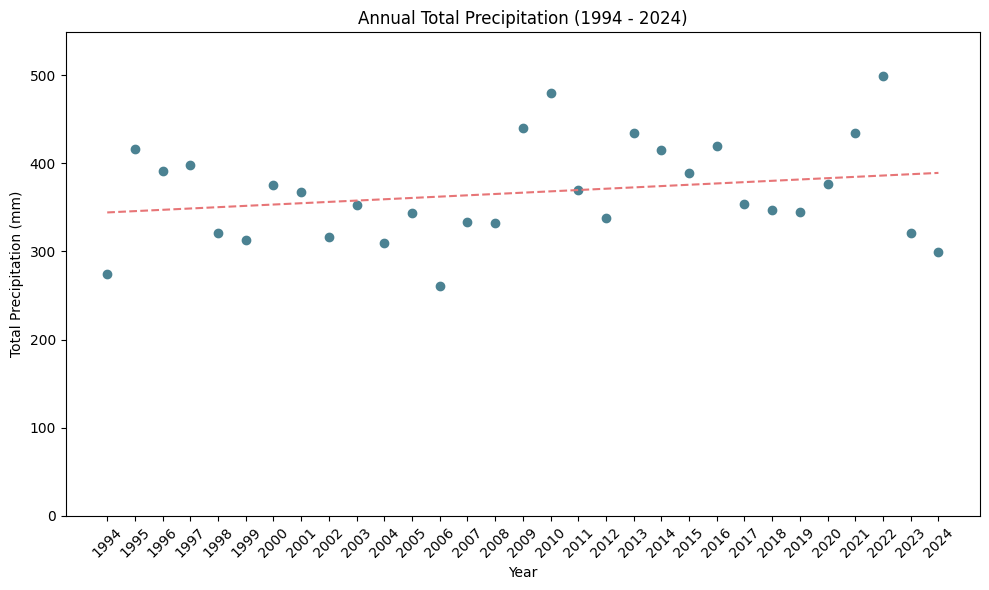

In [19]:
# Load CHIRPS Daily precipitation data
precip_dataset = (ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD')
          .filterDate(start_date, end_date))

# Sum precipitation over the selected period
total = precip_dataset.reduce(ee.Reducer.sum())

# Compute mean precipitation within the given region
stats = total.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=region,
    scale=5000
)

# Define the dry and wet seasons
dry_season_1stmonth = 11
dry_season_lastmonth = 5
wet_season_1stmonth = 6
wet_season_lastmonth = 10

# Filter the dataset for each season
dry_season = filter_by_season(precip_dataset, dry_season_1stmonth, dry_season_lastmonth).filterDate(start_date, end_date)
wet_season = filter_by_season(precip_dataset, wet_season_1stmonth, wet_season_lastmonth).filterDate(start_date, end_date)

# Compute total precipitation sum for dry season
total_dry = dry_season.reduce(ee.Reducer.sum()).reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=region,
    scale=5000
)

# Compute total precipitation sum for wet season
total_wet = wet_season.reduce(ee.Reducer.sum()).reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=region,
    scale=5000
)

# Extract the precipitation sum values
dry_precip_value = total_dry.getInfo().get('precipitation_sum')
wet_precip_value = total_wet.getInfo().get('precipitation_sum')

print(color.BOLD + 'PRECIPITATION 2024' + color.END)
print(f"Total Precipitation: {stats.getInfo().get('precipitation_sum'):.2f} mm")
print(f"Total Dry Season Precipitation: {dry_precip_value:.2f} mm")
print(f"Total Wet Season Precipitation: {wet_precip_value:.2f} mm")

# Define the time range
start_year_prec = 1994
end_year_prec = 2024

# Load CHIRPS precipitation data
chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/PENTAD')

# Initialize a list to store the precipitation values for each year
annual_precipitation = []

# Loop through each year in the range
for year in range(start_year_prec, end_year_prec + 1):
    # Filter CHIRPS data for the specific year
    chirps_year = chirps.filter(ee.Filter.calendarRange(year, year, 'year'))

    # Sum precipitation over the selected year
    total_year = chirps_year.reduce(ee.Reducer.sum())

    # Compute mean precipitation for the year within the given region
    stats_year = total_year.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=region,
        scale=5000
    )

    # Extract the total precipitation for the year
    yearly_precip = stats_year.get('precipitation_sum')

    # Append the result to the list
    annual_precipitation.append((year, yearly_precip.getInfo()))

# Print out the results
#for year, precip in annual_precipitation:
    #print(f"Year {year}: Total Precipitation = {precip:.2f} mm")

# Extract years and precipitation values for plotting
years = [year for year, _ in annual_precipitation]
precipitation = [precip for _, precip in annual_precipitation]

# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(years, precipitation, color ='#4b8292')
plt.title('Annual Total Precipitation (1994 - 2024)')
plt.xlabel('Year')
plt.ylabel('Total Precipitation (mm)')
z = np.polyfit(years, precipitation, 1)
p = np.poly1d(z)
plt.plot(years, p(years), "r--", label="Trend Line", color='#E77577')
plt.grid(True)
plt.xticks(years, rotation=45)
plt.ylim(0, max(precipitation) * 1.1)
plt.grid(False)
plt.tight_layout()
plt.show()

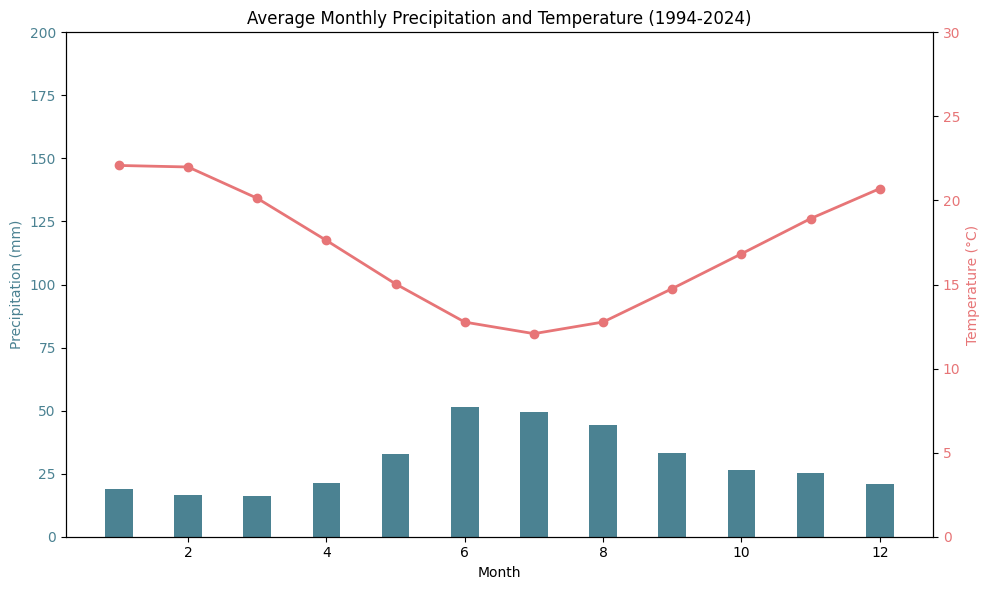

<Figure size 640x480 with 0 Axes>

In [45]:
# Load the ERA5 Monthly dataset for temperature and precipitation
tempDataset = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY_AGGR") \
                .filterDate('1994-01-01', '2024-12-31') \
                .select('temperature_2m')  # Temperature dataset

precipDataset = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY_AGGR") \
                .filterDate('1994-01-01', '2024-12-31') \
                .select('total_precipitation_sum')  # Precipitation dataset

# Extract the month and year from the date to group by month
def add_month_year(image):
    date = ee.Date(image.get('system:time_start'))
    month = date.get('month')
    year = date.get('year')
    return image.set('month', month).set('year', year)

tempWithMonth = tempDataset.map(add_month_year)
precipWithMonth = precipDataset.map(add_month_year)

# Group by month and calculate the mean for both temperature and precipitation
def calculate_monthly_means(month):
    # Filter the datasets by the current month
    tempData = tempWithMonth.filter(ee.Filter.eq('month', month))
    precipData = precipWithMonth.filter(ee.Filter.eq('month', month))

    # Calculate the mean temperature for that month across all years
    tempMean = tempData.mean().reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=region,
        scale=10000,  # Adjust based on your area of interest
        maxPixels=1e8
    )

    # Calculate the mean precipitation for that month across all years
    precipMean = precipData.mean().reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=region,
        scale=10000,  # Adjust based on your area of interest
        maxPixels=1e8
    )

    # Convert temperature from Kelvin to Celsius (subtract 273.15)
    temperatureCelsius = ee.Number(tempMean.get('temperature_2m')).subtract(273.15)

    # Convert precipitation from meters to millimeters (multiply by 1000)
    precipitationMillimeters = ee.Number(precipMean.get('total_precipitation_sum')).multiply(1000)

    # Create a feature with the month, temperature in Celsius, and precipitation in millimeters
    return ee.Feature(None, {
        'month': month,
        'mean_temperature_celsius': temperatureCelsius,
        'mean_precipitation_mm': precipitationMillimeters
    })

# Create a list of months (1 to 12) and calculate the monthly means
monthlyMeans = ee.List.sequence(1, 12).map(calculate_monthly_means)

# Convert the list of features to a FeatureCollection
monthlyMeansFC = ee.FeatureCollection(monthlyMeans)

# Print the result to check
#print(monthlyMeansFC.getInfo())

# Create the combo chart (Bar + Line)
import matplotlib.pyplot as plt
import numpy as np

# Extract the monthly data from the FeatureCollection
features = monthlyMeansFC.getInfo()['features']
months = [feature['properties']['month'] for feature in features]
temperatures = [feature['properties']['mean_temperature_celsius'] for feature in features]
precipitation = [feature['properties']['mean_precipitation_mm'] for feature in features]

# Plot the data
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot precipitation as bars
ax1.bar(months, precipitation, color='#4b8292', width=0.4, label='Precipitation (mm)', align='center')
ax1.set_xlabel('Month')
ax1.set_ylabel('Precipitation (mm)', color='#4b8292')
ax1.tick_params(axis='y', labelcolor='#4b8292')

# Set the y-axis limit for precipitation (0 to 200 mm)
ax1.set_ylim(0, 200)

# Create a second y-axis for the temperature
ax2 = ax1.twinx()
ax2.plot(months, temperatures, color='#E77577', label='Temperature (°C)', marker='o', linestyle='-', linewidth=2)
ax2.set_ylabel('Temperature (°C)', color='#E77577')
ax2.tick_params(axis='y', labelcolor='#E77577')

# Set the y-axis limit for temperature (0 to 30°C)
ax2.set_ylim(0, 30)

# Set chart title
plt.title('Average Monthly Precipitation and Temperature (1994-2024)')

# Show the plot
plt.tight_layout()
plt.show()

plt.savefig('precipitation_temp_plot.png', format='png')


## Floods

In [21]:
#floods -  MODIS Global Flood Database (GFD) and JRC permanent water mask
gfd = ee.ImageCollection('GLOBAL_FLOOD_DB/MODIS_EVENTS/V1')
jrc = (ee.ImageCollection('JRC/GSW1_4/YearlyHistory')
       .select('waterClass')
       .map(lambda img: img.eq(3))  # Permanent water class
       .max())

# Define years for flood analysis
years = ee.List.sequence(2000, 2018)

# Convert flood counts to FeatureCollection
flood_counts_fc = ee.FeatureCollection(years.map(count_flood_events))

total_floods = flood_counts_fc.aggregate_sum('flood_count').getInfo()

# Classify risk
if total_floods == 0:
    risk_level = "Low risk"
elif total_floods == 1:
    risk_level = "Medium risk"
else:
    risk_level = "High risk"

print(color.BOLD + 'FLOODS 2000-2018' + color.END)
if total_floods > 0:
    print('Floods detected in the project area')
else:
    print('No floods detected in the project area')
print('Number of total flood events:', total_floods)
#print(f'Flood Risk Level: {risk_level}')
print(color.PURPLE + f"Flood Risk Level: {risk_level}" + color.END)

FLOODS 2000-2018
No floods detected in the project area
Number of total flood events: 0
Flood Risk Level: Low risk


## Drought

In [24]:
#drought - SPEI dataset
spei_dataset = ee.ImageCollection("CSIC/SPEI/2_10") \
    .filterBounds(region) \
    .filterDate("1992-01-01", "2022-01-01")

# Compute average SPEI indices
spei_avg = spei_dataset.reduce(ee.Reducer.mean()).clip(region).select([
    "SPEI_03_month_mean", "SPEI_06_month_mean", "SPEI_09_month_mean", "SPEI_12_month_mean"
])

# Compute drought risk based on SPEI-9
chart_data = spei_dataset.map(lambda image:
    ee.Feature(None, {
        "Date": image.get("system:time_start"),
        "SPEI_09_month": image.select("SPEI_09_month").reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=region.geometry(),
            scale=55660,
            maxPixels=1e9
        ).get("SPEI_09_month")
    })
)

# Convert to FeatureCollection
chart_list = chart_data.toList(chart_data.size())

# Filter drought events (SPEI-9 < -1.5)
drought_events = chart_list.filter(ee.Filter.lt("SPEI_09_month", -1.5))

# Compute drought risk percentage
total_features = chart_list.size()
num_drought_events = drought_events.size()
percentage_drought = ee.Number(num_drought_events).divide(total_features).multiply(100)

# Classify drought risk
risk_level = ee.Algorithms.If(
    percentage_drought.lt(5), "Low risk",
    ee.Algorithms.If(percentage_drought.lt(15), "Medium risk", "High risk")
)

percentage_drought = percentage_drought.getInfo()

# Print drought risk
print(color.BOLD + 'DROUGHT 1992-2022' + color.END)
print(f"Months with severe drought: {percentage_drought:.2f} %")
#print("Drought Risk Level:", risk_level.getInfo())
print(color.PURPLE + f"Drought Risk Level: {risk_level.getInfo()}" + color.END)



DROUGHT 1992-2022
Months with severe drought: 0.00 %
Drought Risk Level: Low risk


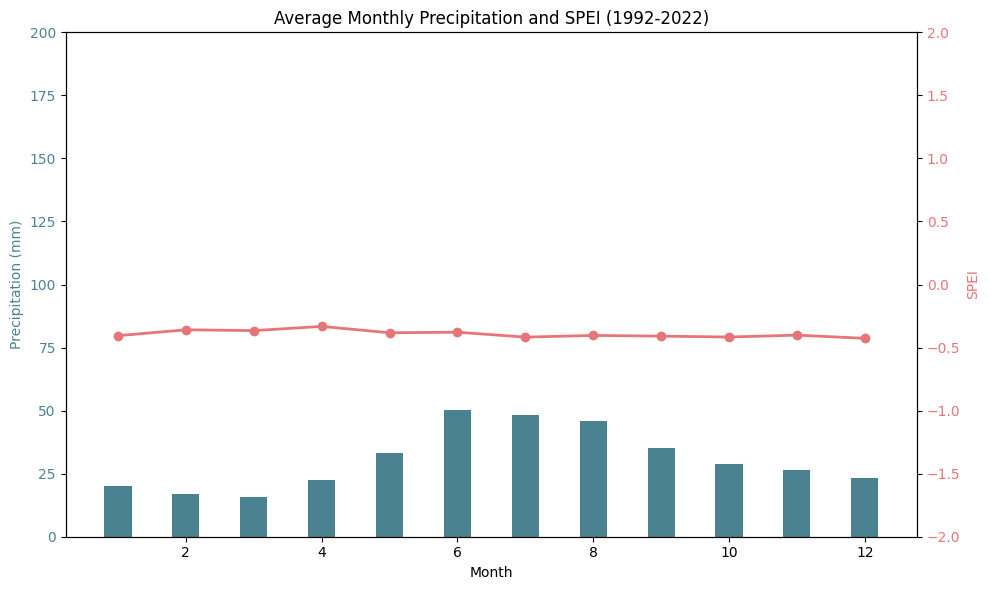

In [37]:
# Load the datasets for SPEI and Precipitation
precipDataset = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY_AGGR") \
                .filterDate('1992-01-01', '2024-12-31') \
                .select('total_precipitation_sum')

speiDataset = ee.ImageCollection("CSIC/SPEI/2_10") \
                .filterBounds(region) \
                .filterDate('1992-01-01', '2022-01-01') \
                .select("SPEI_09_month")

# Extract the month and year from the date to group by month
def add_month_year(image):
    date = ee.Date(image.get('system:time_start'))
    month = date.get('month')
    year = date.get('year')
    return image.set('month', month).set('year', year)

precipWithMonth = precipDataset.map(add_month_year)
speiWithMonth = speiDataset.map(add_month_year)

# Group by month and calculate the mean for both precipitation and SPEI
def calculate_monthly_means(month):
    # Filter the datasets by the current month
    precipData = precipWithMonth.filter(ee.Filter.eq('month', month))
    speiData = speiWithMonth.filter(ee.Filter.eq('month', month))

    # Calculate the mean precipitation for that month across all years
    precipMean = precipData.mean().reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=region,
        scale=10000,  # Adjust based on your area of interest
        maxPixels=1e8
    )

    # Calculate the mean SPEI for that month across all years
    speiMean = speiData.mean().reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=region,
        scale=10000,  # Adjust based on your area of interest
        maxPixels=1e8
    )

    # Convert precipitation from meters to millimeters (multiply by 1000)
    precipitationMillimeters = ee.Number(precipMean.get('total_precipitation_sum')).multiply(1000)

    # Get the SPEI value
    speiValue = ee.Number(speiMean.get('SPEI_09_month'))

    # Create a feature with the month, precipitation in millimeters, and SPEI value
    return ee.Feature(None, {
        'month': month,
        'mean_precipitation_mm': precipitationMillimeters,
        'mean_spei': speiValue
    })

# Create a list of months (1 to 12) and calculate the monthly means
monthlyMeans = ee.List.sequence(1, 12).map(calculate_monthly_means)

# Convert the list of features to a FeatureCollection
monthlyMeansFC = ee.FeatureCollection(monthlyMeans)

# Print the result to check
#print(monthlyMeansFC.getInfo())

# Create the combo chart (Bar + Line)
import matplotlib.pyplot as plt
import numpy as np

# Extract the monthly data from the FeatureCollection
features = monthlyMeansFC.getInfo()['features']
months = [feature['properties']['month'] for feature in features]
precipitation = [feature['properties']['mean_precipitation_mm'] for feature in features]
spei = [feature['properties']['mean_spei'] for feature in features]

# Plot the data
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot precipitation as bars
ax1.bar(months, precipitation, color='#4b8292', width=0.4, label='Precipitation (mm)', align='center')
ax1.set_xlabel('Month')
ax1.set_ylabel('Precipitation (mm)', color='#4b8292')
ax1.tick_params(axis='y', labelcolor='#4b8292')

# Set the y-axis limit for precipitation (0 to 200 mm)
ax1.set_ylim(0, 200)

# Create a second y-axis for the SPEI
ax2 = ax1.twinx()
ax2.plot(months, spei, color='#E77577', label='SPEI', marker='o', linestyle='-', linewidth=2)
ax2.set_ylabel('SPEI', color='#E77577')
ax2.tick_params(axis='y', labelcolor='#E77577')

# Set the y-axis limit for SPEI (-2 to 2)
ax2.set_ylim(-2, 2)

# Set chart title
plt.title('Average Monthly Precipitation and SPEI (1992-2022)')
#plt.axhline(y = -1.5, color = 'r', linestyle = '--')

# Show the plot
plt.tight_layout()
plt.show()


    year  burned_area_ha
0      0               0
1      1               0
2      2               0
3      3               0
4      4               0
5      5               0
6      6               0
7      7               0
8      8               0
9      9               0
10    10               0
11    11               0
12    12               0
13    13               0
14    14               0
15    15               0
16    16               0
17    17               0
18    18               0
19    19               0
20    20               0
21    21               0
22    22               0
23    23               0
24    24               0
WILDFIRES 2000-2024
Frequency of big fire years: 0.00%
Fire Risk Level: Low risk


<ipython-input-12-2e620955c282>:103: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(0, df_wf['burned_area_percentage'].max() * 1.1)


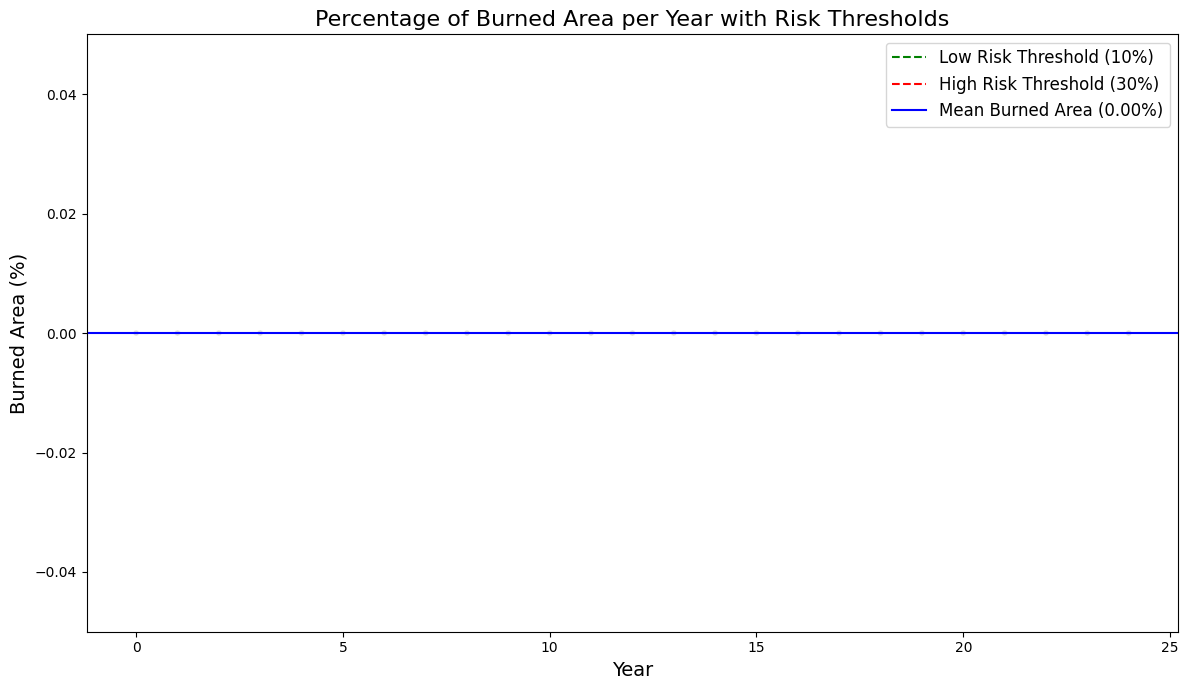

In [ ]:
startDate = ee.Date(wf_startDate)
endDate = ee.Date(wf_endDate)

# MODIS Burned Area dataset
sst = ee.ImageCollection("MODIS/061/MCD64A1") \
            .select('BurnDate') \
            .filterDate(startDate, endDate)

# calculate number of years to process
nYears = ee.Number(endDate.difference(startDate, 'year')).round().subtract(1)
#print(f'Number of years: {nYears.getInfo()}')

# processs burned area per year
byYear = ee.FeatureCollection(
    ee.List.sequence(0, nYears).map(process_year)
)

#features from the Earth Engine FeatureCollection
features = byYear.getInfo()['features']

#'area_ha' values and their corresponding years
data = []
for feature in features:
    year = feature['id']  # The id corresponds to the year index (0-9 in your case)
    area_ha = feature['properties']['burned_area_ha']
    data.append({'year': int(year), 'burned_area_ha': area_ha})

#convert to pandas dataframe
df_wf = pd.DataFrame(data)
#print(df_wf)

#retrive lat and long to get the adequate CRS for a correct area calculation
latitude, longitude = get_shapefile_centroid(gdf)
#print(f"Central Point: ({latitude}, {longitude})")
best_epsg = get_best_crs(latitude, longitude)
#print(best_epsg)
#calculate total area
gdf_crs = gdf.to_crs(best_epsg)
total_area_ha = (gdf_crs['geometry'].area/10000).sum()

#add new column to the df with the percentage of burned area per year
df_wf['burned_area_percentage'] = (df_wf['burned_area_ha'] / total_area_ha) * 100

# Calculate mean and standard deviation for area burned in hectares
mean_area_percentage = df_wf['burned_area_percentage'].mean()
std_area_percentage = df_wf['burned_area_percentage'].std()

# Step 1: Identify big fire years
df_wf['is_big_fire_year'] = df_wf['burned_area_percentage'] > 30 #(mean_area_percentage + std_area_percentage)
# Step 2: Calculate frequency of big fire years
big_fire_frequency = df_wf['is_big_fire_year'].mean() * 100  # Frequency in percentage

# Step 3: Classify fire risk
if mean_area_percentage < 10:
    if big_fire_frequency > 20:
        risk_level_wf = "Medium risk"
    else:
        risk_level_wf = "Low risk"
elif 10 <= mean_area_percentage <= 30:
    if big_fire_frequency > 20:
        risk_level_wf = "High risk"
    else:
        risk_level_wf = "Medium risk"
else:
    risk_level_wf = "High risk"


print(color.BOLD + 'WILDFIRES 2000-2024' + color.END)
print(f"Frequency of big fire years: {big_fire_frequency:.2f}%")
print(color.PURPLE + f"Fire Risk Level: {risk_level_wf}" + color.END)

# Define risk thresholds
low_risk_threshold = 10  # Low risk threshold (10%)
high_risk_threshold = 30  # High risk threshold (30%)
mean_threshold = mean_area_percentage  # Mean burned area percentage

# Add a column for point size (optional, for visualization purposes)
df_wf['point_size'] = df_wf['burned_area_percentage'] * 10  # Scale size for better visualization

# Create the scatter plot
plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=df_wf,
    x='year',
    y='burned_area_percentage',
    size='point_size',
    hue='burned_area_percentage',
    palette='coolwarm',
    legend=False
)

# Add horizontal lines for risk thresholds
plt.axhline(y=low_risk_threshold, color='green', linestyle='--', label='Low Risk Threshold (10%)')
plt.axhline(y=high_risk_threshold, color='red', linestyle='--', label='High Risk Threshold (30%)')
plt.axhline(y=mean_threshold, color='blue', linestyle='-', label=f'Mean Burned Area ({mean_threshold:.2f}%)')

# Set labels and title
plt.title(f'Percentage of Burned Area per Year with Risk Thresholds', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Burned Area (%)', fontsize=14)

# Set y-axis limits
plt.ylim(0, df_wf['burned_area_percentage'].max() * 1.1)

# Show legend
plt.legend(loc='upper right', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()